In [1]:
import gc
import os
import sys
import math
import random
import warnings
import pickle
from pathlib import Path
from joblib import Parallel, delayed
from statsmodels.tsa.deterministic import (CalendarFourier,
                                           CalendarSeasonality,
                                           CalendarTimeTrend,
                                           DeterministicProcess)

from tqdm import tqdm
import os
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# from pandarallel import pandarallel
# pandarallel.initialize()
warnings.simplefilter("ignore")
import ctypes as ct
from datetime import timedelta

from sklearn.metrics import mean_absolute_error

import statistics as st
import lightgbm as lgbm
from scipy.stats import norm

In [2]:
sys.path.append('../../')
import src.utils as utils

## Param

In [22]:
targets_cols = ['playerId', 'target1', 'target2', 'target3', 'target4', 'date']
players_cols = ['playerId', 'primaryPositionName', 'birthCity', 'DOY', 'mlbDebutYear', 'DebutAge', 'heightInches', 'weight']
rosters_cols = ['playerId', 'teamId', 'status', 'date']
scores_cols = ['playerId', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances', 'date']

feature_cols1 = ['label_playerId', 'label_primaryPositionName', 'label_teamId',
       'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances',
        "target1_mean","target1_median","target1_std","target1_min","target1_max","target1_skew","target1_kurt",
         "target2_mean","target2_median","target2_std","target2_min","target2_max","target2_skew","target2_kurt",
        "target3_mean","target3_median","target3_std","target3_min","target3_max","target3_skew","target3_kurt",
        "target4_mean","target4_median","target4_std","target4_min","target4_max","target4_skew","target4_kurt",
        "2_target1_mean","2_target1_median","2_target1_std","2_target1_min","2_target1_max","2_target1_skew","2_target1_kurt",
        "2_target2_mean","2_target2_median","2_target2_std","2_target2_min","2_target2_max","2_target2_skew","2_target2_kurt",
        "2_target3_mean","2_target3_median","2_target3_std","2_target3_min","2_target3_max","2_target3_skew","2_target3_kurt",
        "2_target4_mean","2_target4_median","2_target4_std","2_target4_min","2_target4_max","2_target4_skew","2_target4_kurt"] 

feature_cols2 = ['label_playerId', 'label_primaryPositionName', 'label_teamId',
       'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances',
        "target1_mean","target1_median","target1_std","target1_min","target1_max","target1_skew","target1_kurt",
         "target2_mean","target2_median","target2_std","target2_min","target2_max","target2_skew","target2_kurt",
        "target3_mean","target3_median","target3_std","target3_min","target3_max","target3_skew","target3_kurt",
        "target4_mean","target4_median","target4_std","target4_min","target4_max","target4_skew","target4_kurt",
        "2_target1_mean","2_target1_median","2_target1_std","2_target1_min","2_target1_max","2_target1_skew","2_target1_kurt",
        "2_target2_mean","2_target2_median","2_target2_std","2_target2_min","2_target2_max","2_target2_skew","2_target2_kurt",
        "2_target3_mean","2_target3_median","2_target3_std","2_target3_min","2_target3_max","2_target3_skew","2_target3_kurt",
        "2_target4_mean","2_target4_median","2_target4_std","2_target4_min","2_target4_max","2_target4_skew","2_target4_kurt"] 

feature_cols3 = ['label_playerId', 'label_primaryPositionName', 'label_teamId',
       'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances',
        "target1_mean","target1_median","target1_std","target1_min","target1_max","target1_skew","target1_kurt",
         "target2_mean","target2_median","target2_std","target2_min","target2_max","target2_skew","target2_kurt",
        "target3_mean","target3_median","target3_std","target3_min","target3_max","target3_skew","target3_kurt",
        "target4_mean","target4_median","target4_std","target4_min","target4_max","target4_skew","target4_kurt",
        "2_target1_mean","2_target1_median","2_target1_std","2_target1_min","2_target1_max","2_target1_skew","2_target1_kurt",
        "2_target2_mean","2_target2_median","2_target2_std","2_target2_min","2_target2_max","2_target2_skew","2_target2_kurt",
        "2_target3_mean","2_target3_median","2_target3_std","2_target3_min","2_target3_max","2_target3_skew","2_target3_kurt",
        "2_target4_mean","2_target4_median","2_target4_std","2_target4_min","2_target4_max","2_target4_skew","2_target4_kurt"] 

feature_cols4 = ['week_day', 'annual_day', 'month', 'label_playerId', 'label_primaryPositionName', 'label_teamId', 'label_birthCity',
                'DOY', 'mlbDebutYear', 'DebutAge', 'heightInches', 'weight',
       'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances',
        "target1_mean","target1_median","target1_std","target1_min","target1_max","target1_skew","target1_kurt",
         "target2_mean","target2_median","target2_std","target2_min","target2_max","target2_skew","target2_kurt",
        "target3_mean","target3_median","target3_std","target3_min","target3_max","target3_skew","target3_kurt",
        "target4_mean","target4_median","target4_std","target4_min","target4_max","target4_skew","target4_kurt",
        "2_target1_mean","2_target1_median","2_target1_std","2_target1_min","2_target1_max","2_target1_skew","2_target1_kurt",
        "2_target2_mean","2_target2_median","2_target2_std","2_target2_min","2_target2_max","2_target2_skew","2_target2_kurt",
        "2_target3_mean","2_target3_median","2_target3_std","2_target3_min","2_target3_max","2_target3_skew","2_target3_kurt",
        "2_target4_mean","2_target4_median","2_target4_std","2_target4_min","2_target4_max","2_target4_skew","2_target4_kurt"] 

In [4]:
# training lightgbm
params1 = {'objective':'mae',
           'reg_alpha': 0.14947461820098767, 
           'reg_lambda': 0.10185644384043743, 
           'n_estimators': 3633, 
           'learning_rate': 0.08046301304430488, 
           'num_leaves': 674, 
           'feature_fraction': 0.9101240539122566, 
           'bagging_fraction': 0.9884451442950513, 
           'bagging_freq': 8, 
           'min_child_samples': 51}

params2 = {'objective':'mae',
           'reg_alpha': 0.1,
           'reg_lambda': 0.1, 
           'n_estimators': 80,
           'learning_rate': 0.1,
           'random_state': 42,
           "num_leaves": 22}

params3 = {'objective':'mae',
           'reg_alpha': 0.1,
           'reg_lambda': 0.1, 
           'n_estimators': 10000,
           'learning_rate': 0.1,
           'random_state': 42,
           "num_leaves": 100}

params4 = {'objective':'mae',
           'reg_alpha': 0.016468100279441976, 
           'reg_lambda': 0.09128335764019105, 
           'n_estimators': 9868, 
           'learning_rate': 0.10528150510326864, 
           'num_leaves': 157, 
           'feature_fraction': 0.5419185713426886, 
           'bagging_fraction': 0.2637405128936662, 
           'bagging_freq': 19, 
           'min_child_samples': 71}

In [8]:
EXP_NUM = 15
NFOLDS = 5

## Dir

In [9]:
DATA_DIR = Path("/home/knikaido/work/MLB-Player-Digital-Engagement-Forecasting/data/")
MAIN_DATA_DIR = DATA_DIR / 'mlb-player-digital-engagement-forecasting'
TRAIN_DIR = MAIN_DATA_DIR / 'train'
OUTPUT_DIR = Path('./output/')

In [10]:
players = pd.read_csv(MAIN_DATA_DIR / 'players.csv')

rosters = pd.read_csv(TRAIN_DIR / 'rosters_train.csv')
targets = pd.read_csv(TRAIN_DIR / 'nextDayPlayerEngagement_train.csv')
scores = pd.read_csv(TRAIN_DIR / 'playerBoxScores_train.csv')
scores = scores.groupby(['playerId', 'date']).sum().reset_index()

In [11]:
def calc_probs(pid,df,temp):
    to_append=[pid,'','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','']
    targets=['target1','target2','target3','target4']
    z=1
    for target in targets:
        target_prob = temp[target].tolist()
        mean = np.mean(target_prob)
        std = np.std(target_prob)
        median = st.median(target_prob)
        distribution = norm(mean, std)
        min_weight = min(target_prob)
        max_weight = max(target_prob)
        values = list(np.linspace(min_weight, max_weight))
        probabilities = [distribution.pdf(v) for v in values]
        max_value = max(probabilities)
        max_index = probabilities.index(max_value)
        to_append[z]=mean
        to_append[z+1]=median
        to_append[z+2]=std
        to_append[z+3]=min_weight
        to_append[z+4]=max_weight
        to_append[z+5]=target_prob[max_index]
        to_append[z+6]=temp[target].skew()
        to_append[z+7]=temp[target].kurt()

        z=z+8
    df_length = len(df)
    df.loc[df_length] = to_append
    return df
    



In [12]:
### CREATE DATAFRAME to store probabilities
column_names = ["playerId", "target1_mean","target1_median","target1_std","target1_min","target1_max","target1_prob","target1_skew","target1_kurt",
                "target2_mean","target2_median","target2_std","target2_min","target2_max","target2_prob","target2_skew","target2_kurt",
                "target3_mean","target3_median","target3_std","target3_min","target3_max","target3_prob","target3_skew","target3_kurt",
                "target4_mean","target4_median","target4_std","target4_min","target4_max","target4_prob","target4_skew","target4_kurt",]

targets_train = targets[(targets['date'] >= 20210331)]
playerId_list = targets_train['playerId'].unique()
player_target_probs = pd.DataFrame(columns = column_names)

for pid in tqdm(playerId_list):
    temp = targets_train[targets_train['playerId'] == pid]
    player_target_stats=calc_probs(pid,player_target_probs,temp)

100%|██████████| 2061/2061 [00:44<00:00, 46.79it/s]


In [13]:
### CREATE DATAFRAME to store probabilities
column_names2 = ["playerId", "2_target1_mean","2_target1_median","2_target1_std","2_target1_min","2_target1_max","2_target1_prob","2_target1_skew","2_target1_kurt",
                "2_target2_mean","2_target2_median","2_target2_std","2_target2_min","2_target2_max","2_target2_prob","2_target2_skew","2_target2_kurt",
                "2_target3_mean","2_target3_median","2_target3_std","2_target3_min","2_target3_max","2_target3_prob","2_target3_skew","2_target3_kurt",
                "2_target4_mean","2_target4_median","2_target4_std","2_target4_min","2_target4_max","2_target4_prob","2_target4_skew","2_target4_kurt",]

targets_train = targets[(targets['date'] < 20210331) & (targets['date'] >= 20210228)]
playerId_list = targets_train['playerId'].unique()
player_target_probs = pd.DataFrame(columns = column_names2)

for pid in tqdm(playerId_list):
    temp = targets_train[targets_train['playerId'] == pid]
    player_target_stats2=calc_probs(pid,player_target_probs,temp)

100%|██████████| 2061/2061 [00:44<00:00, 46.81it/s]


In [14]:
players['DOY'] = pd.to_datetime(players['DOB'], format="%Y-%m-%d").dt.year
players['mlbDebutYear'] = pd.to_datetime(players['mlbDebutDate'], format="%Y-%m-%d").dt.year
players['DebutAge'] = players['mlbDebutYear'] - players['DOY']

In [15]:
# creat dataset
train = targets[targets_cols].merge(players[players_cols], on=['playerId'], how='left')
train = train.merge(rosters[rosters_cols], on=['playerId', 'date'], how='left')
train = train.merge(scores[scores_cols], on=['playerId', 'date'], how='left')
train = train.merge(player_target_stats, how='inner', left_on=["playerId"],right_on=["playerId"])
train = train.merge(player_target_stats2, how='inner', left_on=["playerId"],right_on=["playerId"])

In [16]:
# label encoding
player2num = {c: i for i, c in enumerate(train['playerId'].unique())}
position2num = {c: i for i, c in enumerate(train['primaryPositionName'].unique())}
birthCityn2num = {c: i for i, c in enumerate(train['birthCity'].unique())}
teamid2num = {c: i for i, c in enumerate(train['teamId'].unique())}
status2num = {c: i for i, c in enumerate(train['status'].unique())}
train['label_playerId'] = train['playerId'].map(player2num)
train['label_primaryPositionName'] = train['primaryPositionName'].map(position2num)
train['label_birthCity'] = train['birthCity'].map(birthCityn2num)
train['label_teamId'] = train['teamId'].map(teamid2num)
train['label_status'] = train['status'].map(status2num)

In [17]:
date_ = pd.to_datetime(train['date'], format="%Y%m%d")
train['annual_day'] = (date_ - pd.to_datetime(date_.dt.year, format="%Y")) /  timedelta(days=1)
train['week_day'] = date_.dt.weekday
train['month'] = date_.dt.month

In [18]:
def fit_lgbm(x_train, y_train, x_valid, y_valid, params: dict=None, verbose=100):
    oof_pred = np.zeros(len(y_valid), dtype=np.float32)
    model = lgbm.LGBMRegressor(**params)
    model.fit(x_train, y_train, 
        eval_set=[(x_valid, y_valid)],  
        early_stopping_rounds=verbose, 
        verbose=verbose)
    oof_pred = model.predict(x_valid)
    oof_pred = np.clip(oof_pred, 0, 100)
    score = mean_absolute_error(oof_pred, y_valid)
    print('mae:', score)
    return oof_pred, model, score


In [19]:
train_X = train
train_y = train[['target1', 'target2', 'target3', 'target4']]
tr_idxs = []
val_idxs = []

In [20]:
tr_idx = (train['date'].astype(int) < 20201201)
val_idx = (train['date'].astype(int) >= 20201201) & (train['date'].astype(int) < 20210101)
tr_idxs.append(tr_idx)
val_idxs.append(val_idx)

tr_idx = (train['date'].astype(int) < 20210101)
val_idx = (train['date'].astype(int) >= 20210101) & (train['date'].astype(int) < 20210201)
tr_idxs.append(tr_idx)
val_idxs.append(val_idx)

tr_idx = (train['date'].astype(int) < 20210201)
val_idx = (train['date'].astype(int) >= 20210201) & (train['date'].astype(int) < 20210301)
tr_idxs.append(tr_idx)
val_idxs.append(val_idx)

tr_idx = (train['date'].astype(int) < 20210301)
val_idx = (train['date'].astype(int) >= 20210301) & (train['date'].astype(int) < 20210401)
tr_idxs.append(tr_idx)
val_idxs.append(val_idx)

tr_idx = (train['date'].astype(int) < 20210401)
val_idx = ~tr_idx
tr_idxs.append(tr_idx)
val_idxs.append(val_idx)

In [23]:

model1s = []
model2s = []
model3s = []
model4s = []
oof = np.zeros(train_y.shape) - 1.0
y_valids = np.zeros(train_y.shape) - 1.0

for idx in range(NFOLDS):
    
    tr_idx = tr_idxs[idx]
    val_idx = val_idxs[idx]

    x_train = train_X.loc[tr_idx].reset_index(drop=True)
    y_train = train_y.loc[tr_idx].reset_index(drop=True)
    x_valid = train_X.loc[val_idx].reset_index(drop=True)
    y_valid = train_y.loc[val_idx].reset_index(drop=True)


    oof1, model1, score1 = fit_lgbm(
        x_train[feature_cols1], y_train['target1'],
        x_valid[feature_cols1], y_valid['target1'],
        params1
    )
    oof2, model2, score2 = fit_lgbm(
        x_train[feature_cols2], y_train['target2'],
        x_valid[feature_cols2], y_valid['target2'],
        params2
    )
    oof3, model3, score3 = fit_lgbm(
        x_train[feature_cols3], y_train['target3'],
        x_valid[feature_cols3], y_valid['target3'],
        params3
    )
    oof4, model4, score4 = fit_lgbm(
        x_train[feature_cols4], y_train['target4'],
        x_valid[feature_cols4], y_valid['target4'],
        params4
    )

    score = (score1+score2+score3+score4) / 4
    print(f'score: {score}')
    
    model1s.append(model1)
    model2s.append(model2)
    model3s.append(model3)
    model4s.append(model4)
    oof[val_idx, 0] = oof1
    oof[val_idx, 1] = oof2
    oof[val_idx, 2] = oof3
    oof[val_idx, 3] = oof4
    y_valids[val_idx, 0] = y_valid['target1'].values
    y_valids[val_idx, 1] = y_valid['target2'].values
    y_valids[val_idx, 2] = y_valid['target3'].values
    y_valids[val_idx, 3] = y_valid['target4'].values
    


[LightGBM] [Warning] bagging_fraction is set=0.9884451442950513, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9884451442950513
[LightGBM] [Warning] feature_fraction is set=0.9101240539122566, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9101240539122566
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 0.330535
[200]	valid_0's l1: 0.330496
Early stopping, best iteration is:
[117]	valid_0's l1: 0.330324
mae: 0.33032384072280924
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[8]	valid_0's l1: 1.04435
mae: 1.0443471177230705
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 0.342236
Early stopping, best iteration is:
[21]	valid_0's l1: 0.339305
mae: 0.33930472238848114
[LightGBM] [Warning] bagging_fraction is se

In [24]:
oof_indexes = []
for i in range(NFOLDS):
    oof_indexes.extend(val_idxs[i][val_idxs[i]==True].index.to_list())

In [25]:
y_valids[val_idx, :]
mae = mean_absolute_error(y_valids[oof_indexes, :], oof[oof_indexes, :])
print("mae:", mae)

mae: 0.9078355773807097


In [26]:
oof_df = train[targets_cols]
oof_df.iloc[oof_indexes, 1:5] = oof[oof_indexes, :]

In [27]:
oof_df.iloc[oof_indexes].to_csv(OUTPUT_DIR / f'oof{EXP_NUM}.csv')

In [28]:
oof_df.to_csv(OUTPUT_DIR / f'oof{EXP_NUM}.csv', index=False)

In [29]:
models = np.array([model1s, model2s, model3s, model4s])
with open(OUTPUT_DIR / f"models{EXP_NUM}.pickle", mode="wb") as f:
    pickle.dump(models, f)

In [30]:
weights = [0.05, 0.1, 0.15, 0.2, 0.5]

In [31]:
pred1s = 0
pred2s = 0
pred3s = 0
pred4s = 0
for i in range(NFOLDS):
    pred1 = models[0][i].predict(x_valid[feature_cols1])
    pred2 = models[1][i].predict(x_valid[feature_cols2])
    pred3 = models[2][i].predict(x_valid[feature_cols3])
    pred4 = models[3][i].predict(x_valid[feature_cols4])
    oof_valid_april = np.clip(np.array([pred1, pred2, pred3, pred4]).T, 0, 100)
    mae = mean_absolute_error(y_valid, oof_valid_april)
    print("mae:", mae)
    pred1s += pred1 * weights[i]
    pred2s += pred2 * weights[i]
    pred3s += pred3 * weights[i]
    pred4s += pred4 * weights[i]

mae: 0.9889399488586144
mae: 1.0519896221095637
mae: 0.9490917538527278
mae: 0.9555096828919086
mae: 0.9465751222348889


In [32]:
oof_valid_april = np.clip(np.array([pred1s, pred2s, pred3s, pred4s]).T, 0, 100)

In [33]:
mae = mean_absolute_error(y_valid, oof_valid_april)
print("mae:", mae)

mae: 0.9494509071267503


## EDA pred

In [25]:
importance = pd.DataFrame(model1.feature_importances_, index=feature_cols1, columns=['importance'])
importance = importance.sort_values('importance', ascending=False)
importance.iloc[:30].index

Index(['label_playerId', 'label_teamId', 'target1_mean', 'label_status',
       'target1_skew', 'target4_min', 'target2_mean', 'target2_skew',
       'target4_median', 'target3_skew', 'target1_std', 'target3_mean',
       'target4_mean', 'target2_min', 'target4_skew', 'target1_median',
       'target2_median', 'label_primaryPositionName', 'target1_kurt',
       'target2_std', 'target4_std', 'target2_kurt', 'target3_kurt',
       'target3_median', 'target4_kurt', 'target4_max', 'target3_std',
       'target1_max', 'target1_min', 'target2_max'],
      dtype='object')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

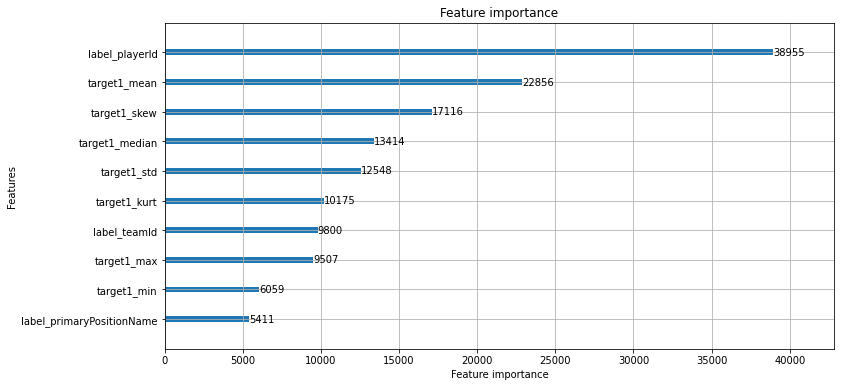

In [27]:
lgbm.plot_importance(model1, figsize=(12, 6), max_num_features=10)

In [28]:
importance = pd.DataFrame(model2.feature_importances_, index=feature_cols2, columns=['importance'])
importance = importance.sort_values('importance', ascending=False)
importance.iloc[:30].index

Index(['label_playerId', 'target2_min', 'target2_median', 'label_status',
       'label_teamId', 'target2_mean', 'label_primaryPositionName',
       'target2_skew', 'target2_std', 'target2_max', 'target2_kurt',
       'plateAppearances', 'battingOrder', 'totalBases', 'winsPitching',
       'inheritedRunners', 'inheritedRunnersScored', 'gamesStartedPitching',
       'rbi', 'inningsPitched', 'saves', 'runsScored', 'saveOpportunities',
       'balks', 'gamesFinishedPitching', 'rbiPitching', 'pickoffsPitching',
       'earnedRuns', 'wildPitches', 'battersFaced'],
      dtype='object')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

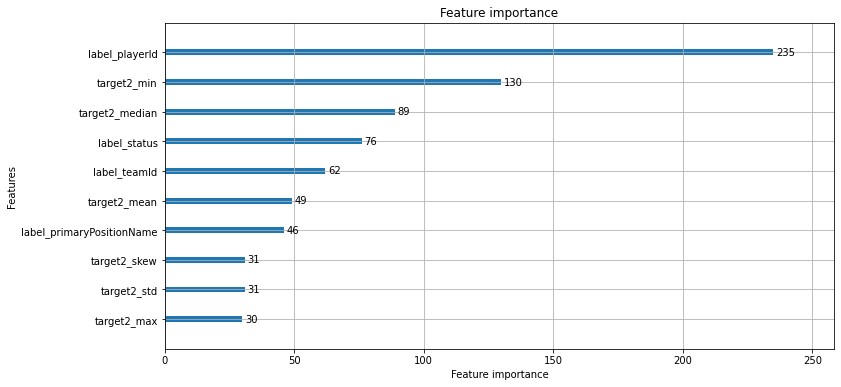

In [29]:
lgbm.plot_importance(model2, figsize=(12, 6), max_num_features=10)

In [30]:
importance = pd.DataFrame(model3.feature_importances_, index=feature_cols3, columns=['importance'])
importance = importance.sort_values('importance', ascending=False)
importance.iloc[:30].index

Index(['label_playerId', 'target3_mean', 'target3_skew', 'target3_median',
       'target3_min', 'target3_kurt', 'target3_max', 'target3_std',
       'label_primaryPositionName', 'label_teamId', 'label_status',
       'plateAppearances', 'inheritedRunners', 'inningsPitched',
       'battingOrder', 'gamesStartedPitching', 'inheritedRunnersScored',
       'totalBases', 'rbi', 'gamesPlayedBatting', 'homeRuns',
       'intentionalWalksPitching', 'gamesFinishedPitching', 'strikes',
       'catchersInterference', 'holds', 'putOuts', 'pitchesThrown', 'balls',
       'outsPitching'],
      dtype='object')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

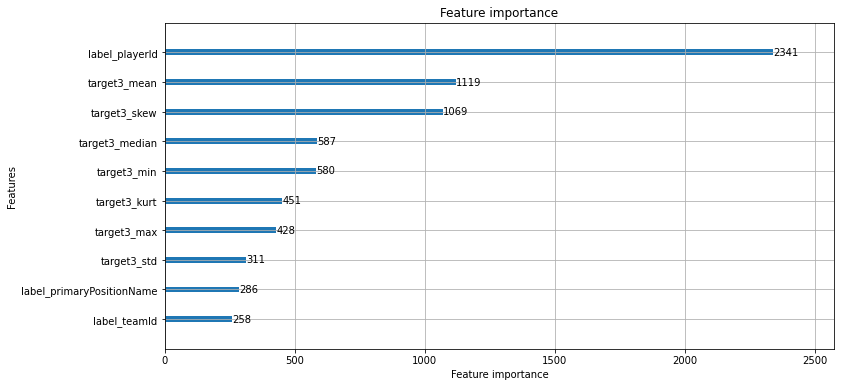

In [31]:
lgbm.plot_importance(model3, figsize=(12, 6), max_num_features=10)

In [45]:
importance = pd.DataFrame(model4.feature_importances_, index=feature_cols4, columns=['importance'])
importance = importance.sort_values('importance', ascending=False)
importance.iloc[:30].index

Index(['annual_day', 'week_day', 'target4_mean', 'month', 'target4_std',
       'label_playerId', 'target4_skew', 'label_teamId', 'mlbDebutYear',
       'label_birthCity', 'target4_median', 'DOY', 'target4_max',
       'label_status', 'weight', 'target4_prob', 'DebutAge', 'target4_kurt',
       'heightInches', 'label_primaryPositionName', 'target4_min',
       'battingOrder', 'plateAppearances', 'totalBases', 'rbi',
       'inningsPitched', 'atBats', 'putOuts', 'homeRuns', 'winsPitching'],
      dtype='object')

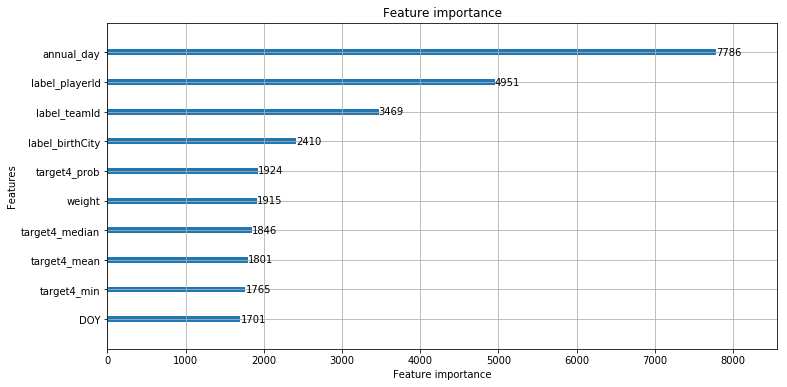

In [24]:
lgbm.plot_importance(model4, figsize=(12, 6), max_num_features=10)

## テストで取ってこれる一行はこんな感じ

In [31]:
example_sample_submission = pd.read_csv(MAIN_DATA_DIR / "example_sample_submission.csv")
example_test = pd.read_csv(MAIN_DATA_DIR / "example_test.csv")
test_df = example_test.set_index('date').iloc[:1]
sample_prediction_df = example_sample_submission[example_sample_submission['date']==test_df.index[0]].set_index('date')

In [52]:
players_cols = ['playerId', 'primaryPositionName', 'birthCity', 'DOY', 'mlbDebutYear', 'DebutAge', 'heightInches', 'weight']
rosters_cols = ['playerId', 'teamId', 'status']
scores_cols = ['playerId', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances']

null = np.nan
true = True
false = False

# env = mlb.make_env() # initialize the environment
# iter_test = env.iter_test() # iterator which loops over each date in test set

# for (test_df, sample_prediction_df) in iter_test: # make predictions here
    
sample_prediction_df = sample_prediction_df.reset_index(drop=True)

# creat dataset
sample_prediction_df['playerId'] = sample_prediction_df['date_playerId']\
                                    .map(lambda x: int(x.split('_')[1]))
# Dealing with missing values
if test_df['rosters'].iloc[0] == test_df['rosters'].iloc[0]:
    test_rosters = pd.DataFrame(eval(test_df['rosters'].iloc[0]))
else:
    test_rosters = pd.DataFrame({'playerId': sample_prediction_df['playerId']})
    for col in rosters.columns:
        if col == 'playerId': continue
        test_rosters[col] = np.nan

if test_df['playerBoxScores'].iloc[0] == test_df['playerBoxScores'].iloc[0]:
    test_scores = pd.DataFrame(eval(test_df['playerBoxScores'].iloc[0]))
else:
    test_scores = pd.DataFrame({'playerId': sample_prediction_df['playerId']})
    for col in scores.columns:
        if col == 'playerId': continue
        test_scores[col] = np.nan
test_scores = test_scores.groupby('playerId').sum().reset_index()
test = sample_prediction_df[['playerId']].copy()
test = test.merge(players[players_cols], on='playerId', how='left')
test = test.merge(test_rosters[rosters_cols], on='playerId', how='left')
test = test.merge(test_scores[scores_cols], on='playerId', how='left')
test = test.merge(player_target_stats, how='inner', left_on=["playerId"],right_on=["playerId"])


test['label_playerId'] = test['playerId'].map(player2num)
test['label_primaryPositionName'] = test['primaryPositionName'].map(position2num)
test['label_teamId'] = test['teamId'].map(teamid2num)
test['label_status'] = test['status'].map(status2num)
test['label_birthCity'] = test['birthCity'].map(birthCityn2num)

date_ = pd.to_datetime(test_df.index[0], format="%Y%m%d")
test['annual_day'] = (date_ - pd.to_datetime(date_.year, format="%Y")) /  timedelta(days=1)
test['week_day'] = date_.weekday()
test['month'] = date_.month


test_X = test

In [54]:
# predict
pred1 = model1.predict(test_X[feature_cols1])
pred2 = model2.predict(test_X[feature_cols2])
pred3 = model3.predict(test_X[feature_cols3])
pred4 = model4.predict(test_X[feature_cols4])

# merge submission
sample_prediction_df['target1'] = np.clip(pred1, 0, 100)
sample_prediction_df['target2'] = np.clip(pred2, 0, 100)
sample_prediction_df['target3'] = np.clip(pred3, 0, 100)
sample_prediction_df['target4'] = np.clip(pred4, 0, 100)
sample_prediction_df = sample_prediction_df.fillna(0.)

del sample_prediction_df['playerId']

In [55]:
sample_prediction_df

,date_playerId,target1,target2,target3,target4
0,20210427_656669,4.523566,7.302453,2.559227e-01,2.723813
1,20210427_543475,0.147992,3.124557,2.008687e-01,1.193542
2,20210427_592866,0.006262,1.240768,1.289277e-02,1.045266
3,20210427_452678,0.028216,3.628774,4.949686e-02,1.776316
4,20210427_570257,0.008472,1.085709,1.132856e-02,0.437531
...,...,...,...,...,...
1182,20210427_593590,0.000010,0.013661,1.073450e-18,0.000000
1183,20210427_642180,0.002000,1.000161,3.896596e-03,0.397934
1184,20210427_663399,0.000242,0.336076,1.736459e-03,0.087545
1185,20210427_664199,0.000847,0.919104,5.898664e-03,0.507688
